In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap

sn.set_context('talk')

# Figures for draft 1 of the ECOREG paper

Converting results from earlier analyses to greyscale and tidying up a bit.

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)
hi_df = hi_df.query('(eco_dataset=="pb") & (time_per==3)') # Just the 3 year dataset

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

## Fig. 1: Site map

In [3]:
# Map
# Map of sites
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=1500000,
            height=1500000,
            resolution='h',
            lat_1=46.5,          # 1st standard parallel
            lat_2=66.5,          # 2st standard parallel
            lon_0=4,lat_0=56.5)  # Central point

# Add map components
m.fillcontinents (color='0.7', lake_color='white')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='white')

# Map (long, lat) to (x, y) for plotting
x, y = m(site_df['lon'].values, site_df['lat'].values)

# Add to df
site_df['east'] = x
site_df['north'] = y

# Get reg and unreg
reg_df = site_df.query('regulated == 1')
ureg_df = site_df.query('regulated == 0')

# Plot
plt.plot(ureg_df['east'], ureg_df['north'], 'sk', 
         mfc='0.5', mec='k', mew=1, 
         markersize=8, label='Unregulated')

plt.plot(reg_df['east'], reg_df['north'], 'ok', 
         mfc='white', mec='k', mew=1, 
         markersize=8, label='Regulated')

#plt.title('ECOREG site locations', fontsize=18)
l = plt.legend(loc='upper left', fontsize=16, 
               frameon=True, fancybox=True)
l.get_frame().set_facecolor('white')
l.get_frame().set_edgecolor('k')

# Save
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\site_map.png'
plt.savefig(out_path, dpi=300)

## Fig. 2: Hydrological regimes

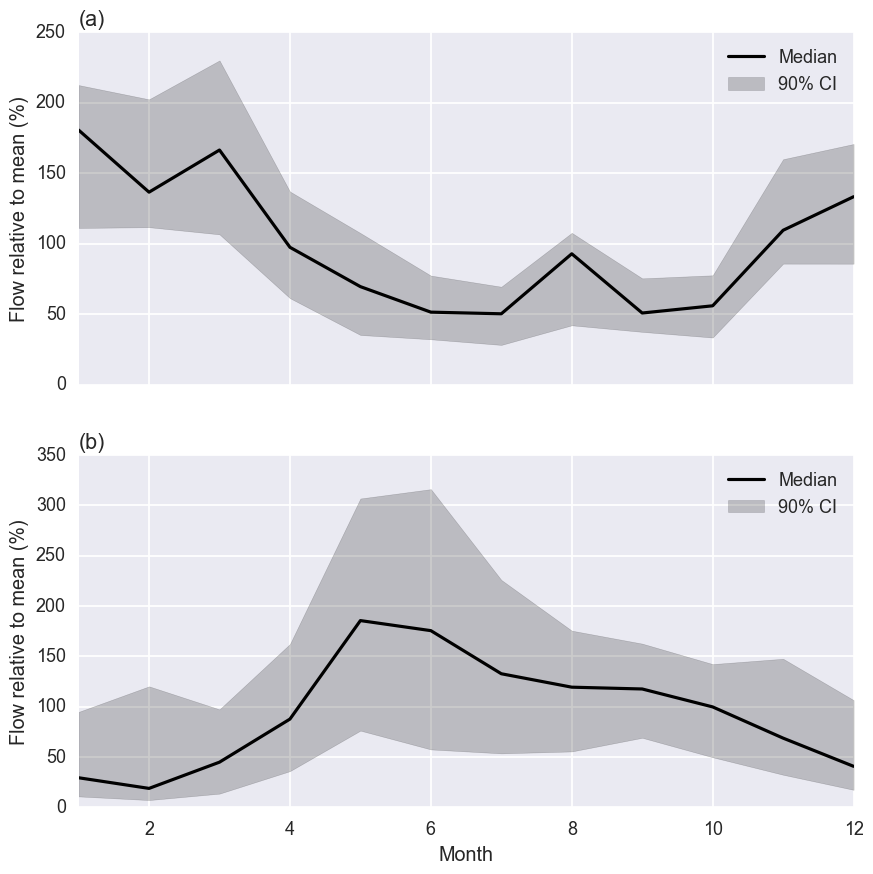

In [4]:
# Extract data of interest
df = hi_df.query('(eco_dataset=="pb") & (time_per==3)')

# Extract cols of interest
cols = ['avg%02d' % mon for mon in range(1, 13)] + ['mean',]
df = df[cols]

# Calculate monthly as % of long-term mean
for col in df.columns:
    df[col] = 100.* df[col] / df['mean']

del df['mean']
    
# Join country 
df = df.join(site_df['country'])

# Calc ststs.
grpd = df.groupby('country')
df = grpd.describe(percentiles=[0.05, 0.50, 0.95])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, 
                         sharex=True, figsize=(10, 10))

# Germany
axes[0].fill_between(range(1, 13), 
                     df.loc['D', '5%'].values,
                     df.loc['D', '95%'].values,
                     color='k', alpha=0.2, 
                     label='90% CI')
axes[0].plot(range(1, 13), 
             df.loc['D', '50%'].values,
             'k-', label='Median')

axes[0].set_ylabel('Flow relative to mean (%)')
axes[0].set_title('(a)', loc='left')
axes[0].legend(loc='best')

# Norway
axes[1].fill_between(range(1, 13), 
                     df.loc['N', '5%'].values,
                     df.loc['N', '95%'].values,
                     color='k', alpha=0.2, 
                     label='90% CI')
axes[1].plot(range(1, 13), 
             df.loc['N', '50%'].values,
             'k-', label='Median')

axes[1].set_ylabel('Flow relative to mean (%)')
axes[1].set_title('(b)', loc='left')
axes[1].legend(loc='best')

plt.xlim((1, 12))
plt.xlabel('Month')

# Save
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\flow_regimes.png'
plt.savefig(out_path, dpi=300)

## Fig. 4: PCA example

In [5]:
def run_pca(df, cols=None, out_png=None):
    """ Applies PCA and generates summary plots.
    
    Args:
        df      Dataframe of features. Must include "country" and "regulated" 
                columns
        cols    Subset of columns to use
        
    Returns:
        Dataframe of PC loadings. Also generates a range of plots.
    """  
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import mpld3

    # Define and markers to use for different categories
    groups_dict = {(u'D', 0):('Unregulated', 'k', 'o'),
                   (u'N', 0):('Unregulated', 'k', 'o'),
                   (u'D', 1):('Regulated', 'k', '^'),
                   (u'N', 1):('Regulated', 'k', '^')}
    
    # Extract cols of interest
    cats = df[['country', 'regulated']]

    if cols:
        df = df[cols].astype(float)

    # Standardise the feature data
    feat_std = StandardScaler().fit_transform(df)

    # Setup PCA. Initially, choose to keep ALL components
    pca = PCA()

    # Fit model
    pca.fit(feat_std)

    # Get explained variances (in %)
    var_exp = 100*pca.explained_variance_ratio_
    cum_exp = np.cumsum(var_exp)

    # Get eigenvalues
    cov_mat = np.cov(feat_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Get number of EVs > 1 (Kaiser-Guttman criterion)
    # and print summary
    n_kgc = (eig_vals > 1).sum()
    print 'Variance explained by first %s PCs (%%):\n' % n_kgc
    print var_exp[:n_kgc]
    print '\nTotal: %.2f%%' % var_exp[:n_kgc].sum()
    
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
      
    # Eigenvalues
    axes[0].plot(range(1, len(eig_vals)+1), np.sort(eig_vals)[::-1], 
                 'k-o', label='Eigenvalues')
    axes[0].axhline(1, c='k', ls='--', label='Kaiser-Guttman threshold')
    axes[0].set_xlabel('Principal component')
    axes[0].set_ylabel('Eigenvalue')
    axes[0].legend(loc='upper right') 
    axes[0].set_title('(a)', loc='left', fontsize=20)
    
    # PC loadings
    loads = pd.DataFrame(data=pca.components_, 
                         columns=df.columns,
                         index=range(1, pca.components_.shape[0]+1)).T
   
    # Refit the PCA, this time specifying 2 components
    # and transforming the result
    feat_reduced = PCA(n_components=2).fit_transform(feat_std)
    
    # Build df 
    data = pd.DataFrame({'PC1':feat_reduced[:, 0],
                         'PC2':feat_reduced[:, 1],
                         'country':cats['country'],
                         'regulated':cats['regulated']})    

    groups = data.groupby(['country', 'regulated'])
    
    # Plot
    for name, group in groups:
        axes[1].scatter(group['PC1'], group['PC2'], s=100, lw=1,
                        label=groups_dict[name][0],
                        marker=groups_dict[name][2],
                        facecolors='white', 
                        edgecolors='k')
        
    axes[1].set_xlabel('First principal component')
    axes[1].set_ylabel('Second principal component')
    axes[1].set_title('(b)', loc='left', fontsize=20)
    l = axes[1].legend(loc='lower right', frameon=True)
    l.get_frame().set_edgecolor('k')
    
    if out_png:
        plt.savefig(out_png, dpi=300)
    
    plt.tight_layout()
    plt.show()

    return loads

Variance explained by first 3 PCs (%):

[ 47.8655807   22.16156081  13.19290031]

Total: 83.22%


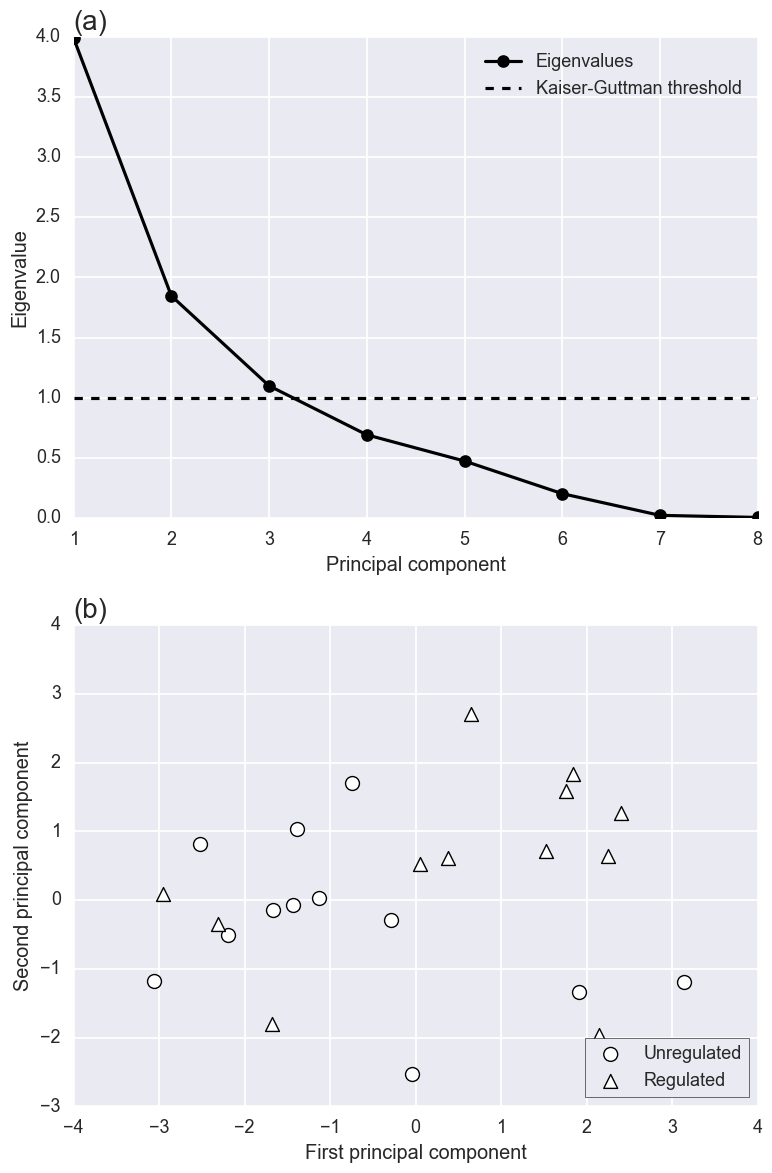

1         2         3         4         5         6  \
pb_rich      0.468368  0.075450  0.192470 -0.365488 -0.172611 -0.019488   
green_rich   0.154014  0.609305  0.337257 -0.374134 -0.151866  0.349557   
cyano_rich   0.424705 -0.225678 -0.195859 -0.260221 -0.391586 -0.562819   
red_rich     0.332611 -0.284598  0.353562 -0.184381  0.780129 -0.067086   
pb_abund     0.443293  0.186695 -0.180382  0.444603  0.030074  0.265881   
green_abund  0.176566  0.619854 -0.242132  0.250270  0.319658 -0.497615   
cyano_abund  0.364278 -0.191951 -0.590233 -0.094231  0.083330  0.486862   
red_abund    0.324845 -0.187642  0.496292  0.596275 -0.274174  0.028572   

                    7         8  
pb_rich     -0.562352  0.507837  
green_rich   0.382802 -0.243962  
cyano_rich   0.225149 -0.376594  
red_rich     0.091932 -0.166788  
pb_abund    -0.443923 -0.519386  
green_abund  0.167733  0.292244  
cyano_abund  0.369436  0.304532  
red_abund    0.341166  0.255018

In [6]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_rich', 'red_rich', 
           'pb_abund', 'green_abund', 'cyano_abund', 'red_abund']

# Run PCA
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\pca_ger_pb.png'
res = run_pca(df, cols=pb_cols, out_png=out_path)
res

## Fig. 5: PPC example

In [40]:
def bayesian_t(df, val_col, grp_col='regulated',
               sig_fac=2, unif_l=0, unif_u=20,
               exp_mn=30, 
               plot_trace=False, plot_ppc=False,
               plot_vars=False, plot_diffs=True,
               steps=2000, mcmc='metropolis'):
    """ Simple Bayesian test for differences between two groups.
    
    Args:
        df         Dataframe. Must have a column containing values
                   and a categorical 'regulated' column that is [0, 1]
                   to define the two groups
        val_col    Name of the values column
        grp_col    Name of the categorical column defining the groups
        sig_fac    Factor applied to std. dev. of pooled data to define
                   prior std. dev. for group means
        unif_l     Lower bound for uniform prior on std. dev. of group
                   means
        unif_u     Upper bound for uniform prior on std. dev. of group
                   means
        exp_mn     Mean of exponential prior for v in Student-T 
                   distribution
        plot_trace Whether to plot the MCMC traces
        plot_ppc   Whether to perform and plot the Posterior Predictive
                   Check 
        plot_vars  Whether to plot posteriors for variables
        plot_diffs Whether to plot posteriors for differences
        steps      Number of steps to take in MCMC chains
        mcmc       Sampler to use: ['metropolis', 'slice', 'nuts']
    
    Returns:
        Creates plots showing the distribution of differences in 
        means and variances, plus optional diagnostics. Returns the 
        MCMC trace
    """
    import numpy as np
    import pymc3 as pm
    import pandas as pd
    import seaborn as sn
    import matplotlib.pyplot as plt

    # Get overall means and s.d.
    mean_all = df[val_col].mean()
    std_all = df[val_col].std()

    # Group data
    grpd = df.groupby(grp_col)
    
    # Separate groups
    reg_data = grpd.get_group(1)[val_col].values
    ureg_data = grpd.get_group(0)[val_col].values   

    # Setup model
    with pm.Model() as model:
        # Priors for means of Student-T dists
        reg_mean = pm.Normal('regulated_mean', mu=mean_all, sd=std_all*sig_fac)
        ureg_mean = pm.Normal('unregulated_mean', mu=mean_all, sd=std_all*sig_fac)

        # Priors for std. dev. of Student-T dists
        reg_std = pm.Uniform('regulated_std', lower=unif_l, upper=unif_u)
        ureg_std = pm.Uniform('unregulated_std', lower=unif_l, upper=unif_u)

        # Prior for v of Student-T dists
        nu = pm.Exponential('v_minus_one', 1./29.) + 1

        # Define Student-T dists
        # PyMC3 uses precision = 1 / (sd^2) to define dists rather than std. dev.
        reg_lam = reg_std**-2
        ureg_lam = ureg_std**-2

        reg = pm.StudentT('regulated', nu=nu, mu=reg_mean, lam=reg_lam, observed=reg_data)
        ureg = pm.StudentT('unregulated', nu=nu, mu=ureg_mean, lam=ureg_lam, observed=ureg_data)

        # Quantities of interest (difference of means and std. devs.)
        diff_of_means = pm.Deterministic('difference_of_means', reg_mean - ureg_mean)
        diff_of_stds = pm.Deterministic('difference_of_stds', reg_std - ureg_std)
        
        # Run sampler to approximate posterior
        if mcmc == 'metropolis':
            trace = pm.sample(steps, step=pm.Metropolis())
        elif mcmc == 'slice':
            trace = pm.sample(steps, step=pm.Slice())
        elif mcmc == 'nuts':
            trace = pm.sample(steps)
        else:
            raise ValueError("mcmc must be one of ['metropolis', 'slice', 'nuts']")

    # Plot results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
        
    # Posteriors for differences
    pm.plot_posterior(trace[1000:],
                      varnames=['difference_of_means', 'difference_of_stds'],
                      ref_val=0,
                      alpha=0.3,
                      ax=axes[0])
    
    # Clear centre titles and set left titles
    axes[0,0].set_title('')
    axes[0,0].set_title('(a)', loc='left')
    axes[0,1].set_title('')
    axes[0,1].set_title('(b)', loc='left')
    axes[0,0].set_ylabel('Frequency')
    axes[0,1].set_ylabel('Frequency')
    axes[0,0].set_xlabel('Difference of means')
    axes[0,1].set_xlabel('Difference of standard deviations')
    
    # Posterior predictive check
    ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)

    sn.distplot([n.mean() for n in ppc['unregulated']], 
                ax=axes[1,0])
    axes[1,0].axvline(ureg_data.mean(), c='k')
    axes[1,0].set_title('(c)', loc='left')
    axes[1,0].set(xlabel='Mean', 
                  ylabel='Frequency',
                  xlim=(0.5, 2))
    axes[1,0].set_yticklabels([])

    sn.distplot([n.mean() for n in ppc['regulated']], 
                ax=axes[1,1])
    axes[1,1].axvline(reg_data.mean(), c='k')
    axes[1,1].set_title('(d)', loc='left')
    axes[1,1].set(xlabel='Mean', 
                  ylabel='Frequency',
                  xlim=(0.5, 2))
    axes[1,1].set_yticklabels([])
    
    fig.tight_layout()

    out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\diffs_nor_cv.png'
    plt.savefig(out_path, dpi=300)
    
    return trace

In [41]:
# Columns to consider
hi_cols = ['mean', 'p50', 'cv', 'revs_per_yr',
           'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']

# Get PB data
df = hi_df[hi_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Run MCMC
trace = bayesian_t(df, 'cv', 
                   plot_trace=True, plot_ppc=True,
                   plot_vars=True, plot_diffs=True,
                   steps=10000, mcmc='slice')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 88.28it/s]
